In [1]:
###############################################################################
# The Institute for the Design of Advanced Energy Systems Integrated Platform
# Framework (IDAES IP) was produced under the DOE Institute for the
# Design of Advanced Energy Systems (IDAES).
#
# Copyright (c) 2018-2024 by the software owners: The Regents of the
# University of California, through Lawrence Berkeley National Laboratory,
# National Technology & Engineering Solutions of Sandia, LLC, Carnegie Mellon
# University, West Virginia University Research Corporation, et al.
# All rights reserved.  Please see the files COPYRIGHT.md and LICENSE.md
# for full copyright and license information.
###############################################################################

import os
import time
from enum import Enum
import pandas as pd
import numpy as np

import pyomo.environ as pyo
from pyomo.common.fileutils import this_file_dir
from pyomo.util.calc_var_value import calculate_variable_from_constraint

import idaes.core.util.scaling as iscale
from idaes.core.solvers import get_solver
import idaes.logger as idaeslog
import idaes.core.util.model_serializer as ms
from idaes.core.util.model_statistics import degrees_of_freedom as dof
from idaes_examples.mod.power_gen.soc_dynamic_flowsheet import SocStandaloneFlowsheet as SocFlowsheet
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from idaes.models.control.controller import ControllerType, ControllerMVBoundType, ControllerAntiwindupType
# from save_results import save_results
from idaes.models.properties import iapws95
from idaes.core.util.model_statistics import degrees_of_freedom as dof
from IPython.display import SVG, display

# SOC Flowsheet --- Steady State Optimization
Author: Douglas Allan
Maintainer: Douglas Allan  
Updated: 2024-23-04

## 1. Introduction

TODO 

## 2. Model Description

TODO

In [2]:
class OperatingScenario(Enum):
    maximum_production = 1
    minimum_production = 2
    power_mode = 3
    neutral = 4

def scale_indexed_constraint(con, sf):
    for idx, c in con.items():
        iscale.constraint_scaling_transform(c, sf)

def set_indexed_variable_bounds(var, bounds):
    for idx, subvar in var.items():
        subvar.bounds = bounds

optarg = {
    "constr_viol_tol": 1e-8,
    "nlp_scaling_method": "user-scaling",
    "linear_solver": "ma57",
    "OF_ma57_automatic_scaling": "yes",
    "max_iter": 300,
    "tol": 1e-8,
    "halt_on_ampl_error": "no",
}

In [3]:
operating_scenario = OperatingScenario.maximum_production
t0 = time.time()
m = pyo.ConcreteModel()
m.fs = SocFlowsheet(
    dynamic=False,
    thin_electrolyte_and_oxygen_electrode=True,
    include_interconnect=True,
    # soc_zfaces=np.linspace(0, 1, 161).tolist()
    soc_zfaces=(
        np.linspace(0, 0.2, 21).tolist()
        + np.linspace(0.2, 0.9, 9).tolist()[1:]
        + np.linspace(0.9, 1, 11).tolist()[1:]
    )
)
iscale.calculate_scaling_factors(m)

2024-06-20 10:29:05 [WARNING] idaes.models.properties.modular_properties.transport_properties.no_method: Skipping construction of thermal conductivity for phase Liq
2024-06-20 10:29:05 [WARNING] idaes.models.properties.modular_properties.transport_properties.no_method: Skipping construction of dynamic viscosity for phase Liq
2024-06-20 10:29:07 [INFO] idaes.models.unit_models.heat_exchanger_1D: For cold_side, a BACKWARD scheme was chosen to discretize the length domain. However, this scheme is not an upwind scheme for countercurrent flow, and as a result may run into numerical stability issues. To avoid this, use a FORWARD scheme (which may result in energy conservation issues for coarse discretizations) or use a high-order collocation method.
2024-06-20 10:29:08 [INFO] idaes.models.unit_models.heat_exchanger_1D: For cold_side, a BACKWARD scheme was chosen to discretize the length domain. However, this scheme is not an upwind scheme for countercurrent flow, and as a result may run into

In [4]:
for t in m.fs.time:
    m.fs.condenser_flash.control_volume.properties_in[t].flow_mol_phase["Liq"].domain = pyo.Reals
    m.fs.condenser_flash.control_volume.properties_in[t].flow_mol_phase["Liq"].bounds = (None, None)
    m.fs.condenser_flash.control_volume.properties_in[t].phase_frac["Liq"].domain = pyo.Reals
    m.fs.condenser_flash.control_volume.properties_in[t].phase_frac["Liq"].bounds = (None, None)
    for var in [
        m.fs.condenser_flash.control_volume.properties_in[t].log_mole_frac_phase_comp,
        m.fs.condenser_flash.control_volume.properties_in[t].log_mole_frac_tdew, 
        m.fs.condenser_flash.control_volume.properties_in[t]._mole_frac_tdew,
        m.fs.condenser_flash.control_volume.properties_out[t]._mole_frac_tdew,
        m.fs.condenser_flash.control_volume.properties_out[t].log_mole_frac_tdew,
        m.fs.condenser_flash.control_volume.properties_out[t].log_mole_frac_phase_comp,
    ]:
        for idx in var.index_set():
            var[idx].domain = pyo.Reals
            var[idx].bounds = (None, None)

In [5]:
if operating_scenario == OperatingScenario.power_mode:
    m.fs.initialize_build(fuel_cell_mode=True, outlvl=idaeslog.INFO, optarg=optarg)
else:
    m.fs.initialize_build(fuel_cell_mode=False, outlvl=idaeslog.INFO, optarg=optarg)

2024-06-20 10:29:13 [INFO] idaes.init.fs.sweep_blower.control_volume.properties_in: Starting initialization
2024-06-20 10:29:13 [INFO] idaes.init.fs.sweep_blower.control_volume.properties_in: State variable initialization completed.
2024-06-20 10:29:14 [INFO] idaes.init.fs.sweep_blower.control_volume.properties_in: Property initialization: optimal - Optimal Solution Found.
2024-06-20 10:29:14 [INFO] idaes.init.fs.sweep_blower.control_volume.properties_out: Starting initialization
2024-06-20 10:29:14 [INFO] idaes.init.fs.sweep_blower.control_volume.properties_out: State variable initialization completed.
2024-06-20 10:29:14 [INFO] idaes.init.fs.sweep_blower.control_volume.properties_out: Property initialization: optimal - Optimal Solution Found.
2024-06-20 10:29:14 [INFO] idaes.init.fs.sweep_blower.control_volume.properties_out: Property package initialization: optimal - Optimal Solution Found.
2024-06-20 10:29:14 [INFO] idaes.init.fs.sweep_blower.properties_isentropic: Starting initial

In [6]:
for var in m.fs.manipulated_variables:
    var.unfix()
m.fs.set_performance_bounds()
m.fs.make_performance_constraints()
m.fs.cooling_water_penalty = pyo.Param(initialize=1e-5, mutable=True)

# set_indexed_variable_bounds(m.fs.feed_heater.electric_heat_duty, (1e6, 2e6))
# set_indexed_variable_bounds(m.fs.sweep_heater.electric_heat_duty, (1e6, 4e6))
set_indexed_variable_bounds(m.fs.feed_heater.electric_heat_duty, (1e6, 10e6))
set_indexed_variable_bounds(m.fs.sweep_heater.electric_heat_duty, (1e6, 10e6))


if operating_scenario == OperatingScenario.power_mode:
    m.fs.makeup_mix.makeup.mole_frac_comp[0, "H2O"].fix(0.03)
    m.fs.makeup_mix.makeup.mole_frac_comp[0, "H2"].fix(0.969)

    set_indexed_variable_bounds(m.fs.condenser_flash.heat_duty, (None, 0))
    set_indexed_variable_bounds(m.fs.condenser_split.split_fraction, (0.00001, 1))
    set_indexed_variable_bounds(m.fs.feed_heater.electric_heat_duty, (1e5, 10e6))
    set_indexed_variable_bounds(m.fs.sweep_heater.electric_heat_duty, (1e5, 10e6))
    
    m.fs.feed_recycle_split.out.mole_frac_comp[0, "H2"].bounds = (0.1, 0.75)
    set_indexed_variable_bounds(m.fs.feed_recycle_split.recycle_ratio, (1e-3, 1))
    set_indexed_variable_bounds(m.fs.sweep_recycle_split.recycle_ratio, (1e-3, 1))
    set_indexed_variable_bounds(m.fs.condenser_split.recycle_ratio, (1e-3, 5))
    
    @m.fs.Constraint(m.fs.time)
    def current_density_average_limit_eqn(b, t):
        return sum([b.soc_module.solid_oxide_cell.current_density[t, iz]
                    for iz in b.soc_module.solid_oxide_cell.iznodes]
                ) / 10 == 4e3

    scale_indexed_constraint(m.fs.current_density_average_limit_eqn, 1e-3)

    # Make sure the steady-state value is nonzero so we don't have trouble with antiwindup
    # because a setpoint is right at a variable bound. We know that optimization won't
    # want a higher value of heat duty because fuel cell mode is exothermic
    m.fs.feed_heater.electric_heat_duty.fix(1e5)
    m.fs.sweep_heater.electric_heat_duty.fix(1e5)

    set_indexed_variable_bounds(m.fs.soc_module.solid_oxide_cell.current_density, (-1.3e4, 5.2e3))

    m.fs.condenser_flash.control_volume.properties_out[:].temperature.fix(273.15+50)
    set_indexed_variable_bounds(m.fs.sweep_blower.inlet.flow_mol, (500, None))
    # Surrogate objective to maximize power output while minimizing H2 mass consumption
    # Note that m.fs.total_electric_power is negative in fuel cell mode because work is
    # leaving the system. 
    m.fs.obj = pyo.Objective(
        expr=(
           1e-8 * m.fs.total_electric_power[0] + m.fs.h2_mass_consumption[0]
        )
    )
elif operating_scenario == OperatingScenario.neutral:
    m.fs.makeup_mix.makeup.mole_frac_comp[0, "H2O"].fix(0.5)
    m.fs.makeup_mix.makeup.mole_frac_comp[0, "H2"].fix(0.499)
    # In this idle steady state, we want net current to be zero
    @m.fs.Constraint(m.fs.time)
    def current_density_average_limit_eqn(b, t):
        return sum([b.soc_module.solid_oxide_cell.current_density[t, iz]
                    for iz in b.soc_module.solid_oxide_cell.iznodes]
                    ) / 10 == 0

    scale_indexed_constraint(m.fs.current_density_average_limit_eqn, 1e-3)

    m.fs.feed_recycle_split.recycle_ratio.fix(1)
    m.fs.sweep_recycle_split.recycle_ratio.fix(1)
    m.fs.condenser_split.recycle_ratio.fix(1)
    m.fs.sweep_blower.inlet.flow_mol.fix(2000)
    m.fs.makeup_mix.makeup.flow_mol.fix(630.5)

    m.fs.condenser_flash.control_volume.properties_out[:].temperature.fix(273.15 + 50)

    # Objective to minimize H2 and power consumption while idling.
    m.fs.obj = pyo.Objective(
        expr=(
            1e-8 * m.fs.total_electric_power[0] + m.fs.h2_mass_consumption[0]
        )
    )

else:
    m.fs.makeup_mix.makeup.mole_frac_comp[0, "H2O"].fix(0.999 - 1e-14)
    m.fs.makeup_mix.makeup.mole_frac_comp[0, "H2"].fix(1e-14)
    if operating_scenario == OperatingScenario.minimum_production:
        m.fs.h2_mass_production.fix(0.4)
    elif operating_scenario == OperatingScenario.maximum_production:
        m.fs.h2_mass_production.fix(2)
    else:
        raise RuntimeError("Please choose a valid operating scenario")
    
    m.fs.feed_recycle_split.out.mole_frac_comp[0, "H2O"].bounds = (0.25, 0.4)
    set_indexed_variable_bounds(m.fs.soc_module.solid_oxide_cell.current_density, (-1.3e4, 5.2e3))
    set_indexed_variable_bounds(m.fs.sweep_blower.inlet.flow_mol, (500, None))


    m.fs.feed_recycle_split.recycle_ratio.fix(1)
    m.fs.sweep_recycle_split.recycle_ratio.fix(1)

    m.fs.condenser_split.split_fraction[:, "recycle"].fix(0.0001)
    m.fs.condenser_split.split_fraction[:, "out"].value = 0.9999
    m.fs.condenser_flash.control_volume.properties_out[:].temperature.fix(273.15 + 50)
    # Minimize total power consumption while operating at a fixed
    # H2 production rate
    m.fs.obj = pyo.Objective(
        expr=(
            1e-8 * m.fs.total_electric_power[0]
        )
    )

@m.fs.Constraint(m.fs.time)
def sweep_concentration_eqn(b, t):
    return b.sweep_recycle_split.mixed_state[t].mole_frac_comp["O2"] <= 0.35


@m.fs.Constraint(m.fs.time)
def min_h2_feed_eqn(b, t):
    return b.feed_recycle_mix.mixed_state[t].mole_frac_comp["H2"] >= 0.05

In [7]:
solver_obj = get_solver(options=optarg)
jac_unscaled, jac_scaled, nlp = iscale.constraint_autoscale_large_jac(m)
results = solver_obj.solve(m, tee=True)
pyo.assert_optimal_termination(results)


component keys that are not exported as part of the NL file.  Skipping.
that are not Var, Constraint, Objective, or the model.  Skipping.
component keys that are not exported as part of the NL file.  Skipping.
that are not Var, Constraint, Objective, or the model.  Skipping.
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-08
max_iter=300
constr_viol_tol=1e-08
linear_solver=ma57
halt_on_ampl_error=no
option_file_name=C:\Users\dallan\AppData\Local\Temp\tmpgmzkgze9_ipopt.opt

Using option file "C:\Users\dallan\AppData\Local\Temp\tmpgmzkgze9_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for 

In [8]:
# from idaes.core.util.model_diagnostics import DiagnosticsToolbox
# m_scaled = pyo.TransformationFactory('core.scale_model').create_using(m, rename=False)
# diag_tbx = DiagnosticsToolbox(m_scaled)


In [9]:
# diag_tbx.display_constraints_with_large_residuals()
# diag_tbx.display_variables_near_bounds()

'SOC Dynamic Flowsheet'

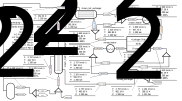

In [10]:
m.fs.write_pfd(fname="soc_dynamic_flowsheet.svg")
display(
    "SOC Dynamic Flowsheet",
    SVG(filename="soc_dynamic_flowsheet.svg"),
)

In [11]:
if operating_scenario == OperatingScenario.minimum_production:
    ms.to_json(m, fname="min_production.json.gz")
elif operating_scenario == OperatingScenario.maximum_production:
    ms.to_json(m, fname="max_production.json.gz")
elif operating_scenario == OperatingScenario.power_mode:
    ms.to_json(m, fname="power_mode.json.gz")
elif operating_scenario == OperatingScenario.neutral:
    ms.to_json(m, fname="neutral.json.gz")

Finished in 68.8505449295044 seconds
Hydrogen production rate: 2 kg/s
Cell potential: 1.3202644837420558 V
Module total current: -191439151.03174606 A
SOC fuel outlet H2 mole frac: 0.7489999432439919
Makeup feed rate: 1324.5391053600388 mol/s
Sweep feed rate: 2261.014098492474 mol/s
Fuel-side heat duty: 1000001.1378089236 W
Fuel-side inlet temperature: 937.7270692395266 K
Fuel side outlet temperature: 981.8008888381352 K
Sweep-side heat duty: 1000003.6789228017 W
Sweep-side inlet temperature: 966.0746425721362 K
Oxygen side outlet temperature: 982.194097132272 K
Stack core temperature: 989.8070227418749 K
Fuel recycle ratio: 1
Sweep recycle ratio: 1
Sweep oxygen outlet: 0.35000000887747595
Feed hydrogen inlet: 0.37453742161916315
Vent gas recirculation recycle ratio 0.00010001000100010001
Condenser heat duty: -15514861.81290435 W
Condenser hydrogen outlet temperature: 323.15 K


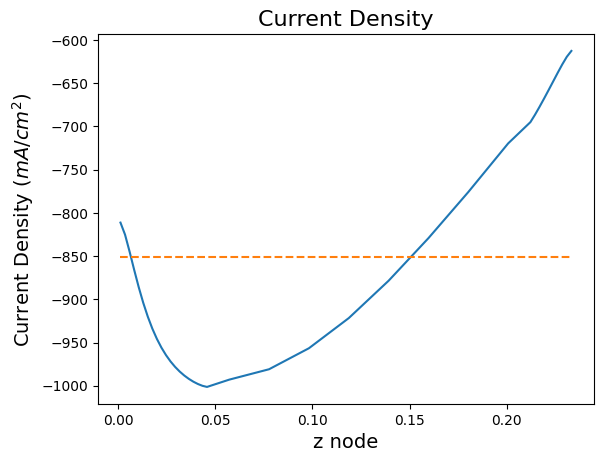

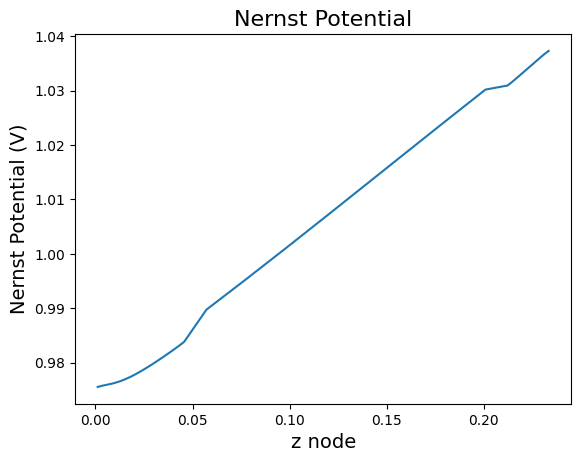

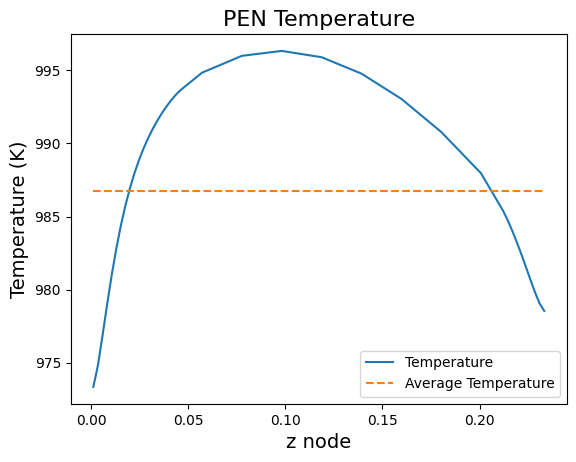

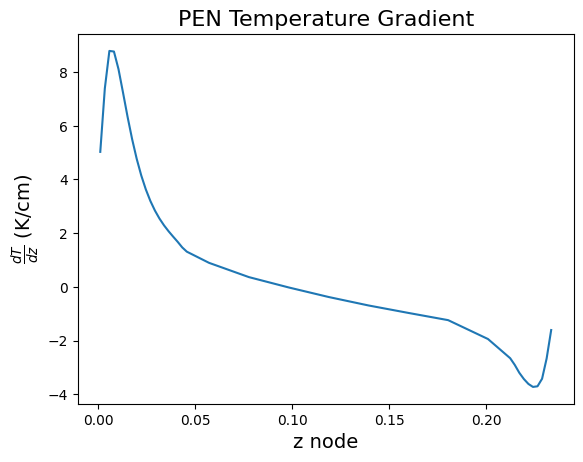

In [12]:
# for var in m.fs.manipulated_variables:
#    print(var.name + f": {var.value}")
#    var.pprint()
t1 = time.time()
print(f"Finished in {t1-t0} seconds")
print(f"Hydrogen production rate: {pyo.value(m.fs.h2_mass_production[0])} kg/s")
print(f"Cell potential: {pyo.value(m.fs.soc_module.potential_cell[0])} V")
print(f"Module total current: {pyo.value(m.fs.soc_module.total_current[0])} A")
print(f"SOC fuel outlet H2 mole frac: {pyo.value(m.fs.soc_module.fuel_outlet_mole_frac_comp_H2[0])}")
print(f"Makeup feed rate: {pyo.value(m.fs.makeup_mix.makeup.flow_mol[0])} mol/s")
#print(f"Hydrogen/water ratio: {pyo.value(m.fs.feed_hydrogen_water_ratio[0])}")
print(f"Sweep feed rate: {pyo.value(m.fs.sweep_blower.inlet.flow_mol[0])} mol/s")
print(f"Fuel-side heat duty: {pyo.value(m.fs.feed_heater.electric_heat_duty[0])} W")
print(f"Fuel-side inlet temperature: {pyo.value(m.fs.soc_module.fuel_inlet.temperature[0])} K")
# print(f"Fuel-side inlet temperature: {pyo.value(m.fs.stack_fuel_inlet_temperature[0])} K")
print(f"Fuel side outlet temperature: {pyo.value(m.fs.soc_module.fuel_outlet.temperature[0])} K")
print(f"Sweep-side heat duty: {pyo.value(m.fs.sweep_heater.electric_heat_duty[0])} W")
print(f"Sweep-side inlet temperature: {pyo.value(m.fs.soc_module.oxygen_inlet.temperature[0])} K")
# print(f"Sweep-side inlet temperature: {pyo.value(m.fs.stack_sweep_inlet_temperature[0])} K")
print(f"Oxygen side outlet temperature: {pyo.value(m.fs.soc_module.oxygen_outlet.temperature[0])} K")
print(f"Stack core temperature: {pyo.value(m.fs.stack_core_temperature[0])} K")
print(f"Fuel recycle ratio: {pyo.value(m.fs.feed_recycle_split.recycle_ratio[0])}")
print(f"Sweep recycle ratio: {pyo.value(m.fs.sweep_recycle_split.recycle_ratio[0])}")
print(f"Sweep oxygen outlet: {pyo.value(m.fs.sweep_recycle_split.mixed_state[0].mole_frac_comp['O2'])}")
print(f"Feed hydrogen inlet: {pyo.value(m.fs.feed_recycle_mix.mixed_state[0].mole_frac_comp['H2'])}")

print(f"Vent gas recirculation recycle ratio {pyo.value(m.fs.condenser_split.recycle_ratio[0])}")
# print(f"Condenser cooling water feed rate: {pyo.value(m.fs.condenser_hx.cold_side_inlet.flow_mol[0])} mol/s")
# print(f"Condenser hydrogen outlet temperature: {pyo.value(m.fs.condenser_hx.hot_side_outlet.temperature[0])} K")
print(f"Condenser heat duty: {pyo.value(m.fs.condenser_flash.heat_duty[0])} W")
print(f"Condenser hydrogen outlet temperature: {pyo.value(m.fs.condenser_flash.vap_outlet.temperature[0])} K")

for hx in [m.fs.feed_medium_exchanger, m.fs.feed_hot_exchanger, m.fs.sweep_exchanger]:
    # Test for energy conservation in heat exchangers
    Delta_E_Cold = pyo.value(
        hx.cold_side.properties[0, 0].flow_mol * hx.cold_side.properties[0, 0].enth_mol
        - hx.cold_side.properties[0, 1].flow_mol * hx.cold_side.properties[0, 1].enth_mol
    )
    Delta_E_Hot = pyo.value(
        hx.hot_side.properties[0, 0].flow_mol * hx.hot_side.properties[0, 0].enth_mol
        - hx.hot_side.properties[0, 1].flow_mol * hx.hot_side.properties[0, 1].enth_mol
    )
    assert abs(2*(Delta_E_Cold-Delta_E_Hot)/(Delta_E_Cold+Delta_E_Hot)) < 1e-3

soc = m.fs.soc_module.solid_oxide_cell

plt.figure()
nz_nodes = len(soc.iznodes)
znodes = np.array(soc.znodes) * pyo.value(soc.length_z)
plt.plot(znodes, np.array(
    [pyo.value(soc.current_density[0, i]) for i in
        soc.iznodes]) / 10, label="Current Density")
plt.plot(znodes, np.ones((nz_nodes, 1)) * sum(
    [pyo.value(soc.current_density[0, i]) for i in
        soc.iznodes]) / (10 * nz_nodes), "--", label="Average Current Density")

plt.xlabel("z node", fontsize=14)
plt.ylabel(r"Current Density ($mA/cm^2$)", fontsize=14)
plt.title("Current Density", fontsize=16)

plt.figure()
plt.plot(znodes, np.array(
    [pyo.value(soc.fuel_triple_phase_boundary.potential_nernst[0, iz]
                + soc.oxygen_triple_phase_boundary.potential_nernst[0, iz])
        for iz in soc.iznodes]),
    label="Nernst Potential"
    )

plt.xlabel("z node", fontsize=14)
plt.ylabel(r"Nernst Potential (V)", fontsize=14)
plt.title("Nernst Potential", fontsize=16)

plt.figure()
plt.plot(znodes, np.array(
    [pyo.value(soc.fuel_electrode.temperature[0, 1, i]) for i in
        soc.iznodes]), label="Temperature")
plt.plot(znodes, np.ones((nz_nodes, 1)) * sum(
    [pyo.value(soc.fuel_electrode.temperature[0, 1, i]) for i in
        soc.iznodes]) / nz_nodes, "--", label="Average Temperature")

plt.legend()
plt.xlabel("z node", fontsize=14)
plt.ylabel("Temperature (K)", fontsize=14)
plt.title("PEN Temperature", fontsize=16)

plt.figure()
plt.plot(znodes, np.array(
    [pyo.value(soc.fuel_electrode.dtemperature_dz[0, 1, i]) for i in
        soc.iznodes])/100) # K/m to K/cm
plt.xlabel("z node", fontsize=14)
plt.ylabel(r"$\frac{dT}{dz}$ (K/cm)", fontsize=14)
plt.title("PEN Temperature Gradient", fontsize=16)

plt.show()

In [13]:
m.fs.soc_module.solid_oxide_cell.model_check()